# Generating PID controller data
This series of notebooks explores the idea of emulating PID controller behavior with an LSTM. This first notebook is used to tune a PID controller and generate data from the TCLab for use in training the LSTM. The LSTM can then be used in place of the PID controller (or any other controller it is trained on), or used to evaluate the PID controller performance for anomaly detection.

In [27]:
import import_ipynb
import tclab
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import random
import pidcontroller

In [29]:
TCLab = tclab.setup(connected=False, speedup=60)

# PID Parameters
Kc   = 6.0
tauI = 75.0 # sec
tauD = 0.0  # sec
out_min = 0
out_max = 100

pid = PidController(Kc, Kc / tauI, -Kc * tauD, out_min, out_max)

TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.


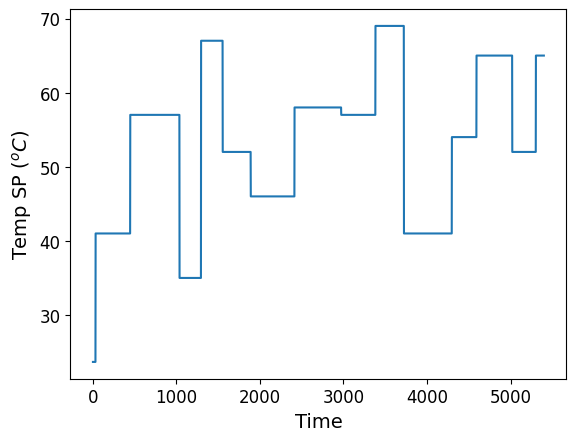

In [30]:
##### Set up run parameters #####

# Run time in minutes
run_time = 90.0

# Number of cycles
loops = int(60.0*run_time)

# arrays for storing data
T1 = np.zeros(loops) # measured T (degC)
Q1 = np.zeros(loops) # Heater values
tm = np.zeros(loops) # Time

# Temperature set point (degC)
with TCLab() as lab:
    Tsp1 = np.ones(loops) * lab.T1

Tsp1[0:31] = 23.67
Tsp1[31:446] = 41
Tsp1[446:1036] = 57
Tsp1[1036:1294] = 35
Tsp1[1294:1553] = 67
Tsp1[1553:1889] = 52
Tsp1[1889:2413] = 46
Tsp1[2413:2972] = 58
Tsp1[2972:3382] = 57
Tsp1[3382:3723] = 69
Tsp1[3723:4297] = 41
Tsp1[4297:4592] = 54
Tsp1[4592:5020] = 65
Tsp1[5020:5303] = 52
Tsp1[5303:] = 65

# # vary temperature setpoint
# end = 30 # leave 1st 30 seconds of temp set point as room temp
# while end <= loops:
#     start = end
#     # keep new temp set point value for anywhere from 4 to 10 min
#     end += random.randint(240,600) 
#     Tsp1[start:end] = random.randint(30,70)

# Plot
plt.plot(Tsp1)
plt.xlabel('Time',size=14)
plt.ylabel(r'Temp SP ($^oC$)',size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.savefig('SP_profile.png');

In [32]:
# Run test
with TCLab() as lab:
    # Find current T1, T2
    print('Temperature 1: {0:0.2f} °C'.format(lab.T1))
    print('Temperature 2: {0:0.2f} °C'.format(lab.T2))

    # Integral error
    ierr = 0.0
    # Integral absolute error
    iae = 0.0

    start_time = 0
    prev_time = -1

    i = 0
    for clock in tclab.clock(run_time * 60):
        if i >= 60.0 * run_time:
            break
        
        # Record time and change in time
        t = clock
        dt = t - prev_time
        prev_time = t
        tm[i] = t - start_time

        # Read temperatures in Kelvin 
        T1[i] = lab.T1

        # Integral absolute error
        iae += np.abs(Tsp1[i]-T1[i])

        Q1[i] = pid.get_output(Tsp1[i], T1[i], dt)

        # Write heater output (0-100)
        lab.Q1(Q1[i])

        # Print line of data
        print(('{:6.1f} {:6.2f} {:6.2f} ' + \
              '{:6.2f} {:6.2f} {:6.2f} {:6.2f} {:6.2f}').format( \
                  tm[i],Tsp1[i],T1[i], \
                  Q1[i],pid.p,pid.i,pid.d,iae))
        
        i += 1
        

TCLab version 0.4.9
Simulated TCLab
Temperature 1: 20.95 °C
Temperature 2: 20.95 °C
   0.0  23.67  20.95  16.78  16.32   0.46  -0.00   2.72
   1.0  23.67  20.95  17.01  16.32   0.68  -0.00   5.44
   2.9  23.67  20.95  17.40  16.32   1.08  -0.00   8.16
   3.8  23.67  20.95  17.61  16.32   1.29  -0.00  10.88
   4.8  23.67  20.95  17.82  16.32   1.49  -0.00  13.60
   5.7  23.67  20.95  18.03  16.32   1.70  -0.00  16.32
   6.6  23.67  20.95  18.22  16.32   1.90  -0.00  19.04
   7.5  23.67  20.95  18.43  16.32   2.10  -0.00  21.76
   8.4  23.67  20.95  18.62  16.32   2.30  -0.00  24.48
   9.4  23.67  20.95  18.83  16.32   2.51  -0.00  27.21
  10.3  23.67  20.95  19.03  16.32   2.70  -0.00  29.93
  11.2  23.67  20.95  19.23  16.32   2.90  -0.00  32.65
  12.2  23.67  20.95  19.43  16.32   3.11  -0.00  35.37
  13.1  23.67  21.27  17.68  14.39   3.29  -0.00  37.76
  14.1  23.67  21.27  17.86  14.39   3.47  -0.00  40.16
  15.9  23.67  21.27  18.22  14.39   3.83  -0.00  42.56
  16.8  23.67  21.27

 145.7  41.00  42.22  32.82  -7.33  40.15   0.00 887.04
 146.7  41.00  42.22  32.73  -7.33  40.06   0.00 888.26
 147.6  41.00  42.22  32.64  -7.33  39.97   0.00 889.48
 148.5  41.00  42.22  32.55  -7.33  39.88   0.00 890.70
 149.4  41.00  42.22  32.46  -7.33  39.79   0.00 891.92
 150.4  41.00  42.22  32.36  -7.33  39.69   0.00 893.14
 151.3  41.00  42.22  32.27  -7.33  39.60   0.00 894.36
 152.2  41.00  42.22  32.19  -7.33  39.51   0.00 895.58
 153.2  41.00  42.22  32.10  -7.33  39.42   0.00 896.81
 154.1  41.00  42.22  32.01  -7.33  39.34   0.00 898.03
 155.0  41.00  42.22  31.91  -7.33  39.24   0.00 899.25
 156.8  41.00  42.54  29.75  -9.26  39.02   0.00 900.79
 157.8  41.00  42.22  31.60  -7.33  38.93  -0.00 902.01
 158.7  41.00  42.54  29.55  -9.26  38.81   0.00 903.56
 159.7  41.00  42.22  31.39  -7.33  38.72  -0.00 904.78
 160.6  41.00  42.22  31.30  -7.33  38.63   0.00 906.00
 161.6  41.00  42.54  29.24  -9.26  38.51   0.00 907.54
 162.5  41.00  42.22  31.08  -7.33  38.41  -0.00

 303.6  41.00  40.93  34.08   0.41  33.67  -0.00 974.95
 304.6  41.00  40.93  34.08   0.41  33.68  -0.00 975.02
 305.5  41.00  40.93  34.09   0.41  33.68  -0.00 975.09
 306.5  41.00  40.93  34.09   0.41  33.69  -0.00 975.16
 307.4  41.00  40.93  34.10   0.41  33.69  -0.00 975.22
 308.4  41.00  40.93  34.10   0.41  33.70  -0.00 975.29
 309.3  41.00  40.93  34.11   0.41  33.70  -0.00 975.36
 310.2  41.00  40.93  34.11   0.41  33.71  -0.00 975.43
 311.2  41.00  40.93  34.12   0.41  33.71  -0.00 975.50
 312.1  41.00  40.93  34.12   0.41  33.72  -0.00 975.56
 313.1  41.00  40.93  34.13   0.41  33.72  -0.00 975.63
 314.0  41.00  40.93  34.13   0.41  33.73  -0.00 975.70
 315.8  41.00  40.93  34.14   0.41  33.74  -0.00 975.77
 316.8  41.00  40.93  34.15   0.41  33.74  -0.00 975.84
 317.7  41.00  40.93  34.15   0.41  33.75  -0.00 975.90
 318.6  41.00  40.93  34.16   0.41  33.75  -0.00 975.97
 319.5  41.00  40.93  34.16   0.41  33.76  -0.00 976.04
 320.4  41.00  40.93  34.17   0.41  33.76  -0.00

 462.3  57.00  42.54 100.00  86.74  33.66  -0.00 1251.42
 463.2  57.00  42.54 100.00  86.74  33.66  -0.00 1265.88
 464.2  57.00  42.87 100.00  84.80  33.66  -0.00 1280.01
 465.1  57.00  42.87 100.00  84.80  33.66  -0.00 1294.14
 466.1  57.00  43.19 100.00  82.87  33.66  -0.00 1307.96
 467.9  57.00  43.51 100.00  80.94  33.66  -0.00 1321.44
 468.8  57.00  43.51 100.00  80.94  33.66  -0.00 1334.93
 469.7  57.00  43.83 100.00  79.00  33.66  -0.00 1348.10
 470.6  57.00  43.83 100.00  79.00  33.66  -0.00 1361.27
 471.5  57.00  44.16 100.00  77.07  33.66  -0.00 1374.11
 472.4  57.00  44.16 100.00  77.07  33.66  -0.00 1386.96
 473.3  57.00  44.48 100.00  75.14  33.66  -0.00 1399.48
 474.2  57.00  44.80 100.00  73.20  33.66  -0.00 1411.68
 475.2  57.00  44.80 100.00  73.20  33.66  -0.00 1423.88
 476.1  57.00  45.12 100.00  71.27  33.66  -0.00 1435.76
 477.0  57.00  45.12 100.00  71.27  33.66  -0.00 1447.64
 478.9  57.00  45.77 100.00  67.40  33.66  -0.00 1458.87
 479.8  57.00  45.77 100.00  67

 608.2  57.00  57.37  58.24  -2.22  60.46   0.00 1840.43
 609.2  57.00  57.37  58.21  -2.22  60.43   0.00 1840.80
 610.1  57.00  57.37  58.19  -2.22  60.40   0.00 1841.17
 612.0  57.00  57.37  58.13  -2.22  60.35   0.00 1841.54
 612.8  57.00  57.37  58.11  -2.22  60.32   0.00 1841.91
 613.8  57.00  57.37  58.08  -2.22  60.30   0.00 1842.28
 614.7  57.00  57.37  58.05  -2.22  60.27   0.00 1842.65
 615.6  57.00  57.37  58.02  -2.22  60.24   0.00 1843.02
 616.5  57.00  57.37  58.00  -2.22  60.21   0.00 1843.38
 617.4  57.00  57.05  59.93  -0.28  60.21  -0.00 1843.43
 618.4  57.00  57.05  59.92  -0.28  60.21   0.00 1843.48
 619.3  57.00  57.05  59.92  -0.28  60.20   0.00 1843.53
 620.2  57.00  57.37  57.96  -2.22  60.18   0.00 1843.90
 621.1  57.00  57.05  59.89  -0.28  60.17  -0.00 1843.94
 622.1  57.00  57.05  59.89  -0.28  60.17   0.00 1843.99
 623.9  57.00  57.05  59.88  -0.28  60.16   0.00 1844.04
 624.8  57.00  57.05  59.88  -0.28  60.16   0.00 1844.08
 625.7  57.00  57.05  59.87  -0

 753.2  57.00  57.05  59.90  -0.28  60.18   0.00 1855.59
 754.1  57.00  56.72  61.85   1.65  60.20   0.00 1855.87
 755.0  57.00  57.05  59.91  -0.28  60.20   0.00 1855.92
 756.0  57.00  56.72  61.87   1.65  60.22   0.00 1856.19
 757.9  57.00  57.05  59.93  -0.28  60.21   0.00 1856.24
 758.8  57.00  57.05  59.92  -0.28  60.21   0.00 1856.29
 759.8  57.00  56.72  61.88   1.65  60.23   0.00 1856.56
 760.7  57.00  57.05  59.94  -0.28  60.22   0.00 1856.61
 761.6  57.00  57.05  59.94  -0.28  60.22   0.00 1856.66
 762.5  57.00  57.05  59.93  -0.28  60.22   0.00 1856.70
 763.4  57.00  57.05  59.93  -0.28  60.21   0.00 1856.75
 764.4  57.00  57.05  59.93  -0.28  60.21   0.00 1856.80
 765.3  57.00  56.72  61.88   1.65  60.23   0.00 1857.07
 766.2  57.00  56.72  61.90   1.65  60.25  -0.00 1857.35
 767.2  57.00  56.72  61.92   1.65  60.27  -0.00 1857.62
 768.1  57.00  57.05  59.99  -0.28  60.27   0.00 1857.67
 770.0  57.00  57.05  59.98  -0.28  60.26   0.00 1857.72
 770.9  57.00  57.05  59.98  -0

 908.8  57.00  57.05  59.98  -0.28  60.26   0.00 1868.83
 909.8  57.00  57.05  59.98  -0.28  60.26   0.00 1868.87
 910.7  57.00  57.05  59.97  -0.28  60.25   0.00 1868.92
 911.6  57.00  57.05  59.97  -0.28  60.25   0.00 1868.97
 912.6  57.00  57.05  59.97  -0.28  60.25   0.00 1869.01
 913.5  57.00  57.05  59.96  -0.28  60.24   0.00 1869.06
 914.4  57.00  57.05  59.96  -0.28  60.24   0.00 1869.11
 915.4  57.00  57.05  59.95  -0.28  60.24   0.00 1869.16
 916.3  57.00  57.05  59.95  -0.28  60.23   0.00 1869.20
 917.2  57.00  57.05  59.95  -0.28  60.23   0.00 1869.25
 918.1  57.00  57.05  59.94  -0.28  60.23   0.00 1869.30
 919.1  57.00  57.05  59.94  -0.28  60.22   0.00 1869.34
 920.9  57.00  57.05  59.93  -0.28  60.22   0.00 1869.39
 921.8  57.00  57.05  59.93  -0.28  60.21   0.00 1869.44
 922.8  57.00  57.05  59.93  -0.28  60.21   0.00 1869.49
 923.7  57.00  57.05  59.92  -0.28  60.21   0.00 1869.53
 924.6  57.00  57.05  59.92  -0.28  60.20   0.00 1869.58
 925.5  57.00  57.05  59.92  -0

1053.4  35.00  55.44   0.00 -122.61  60.24   0.00 2263.51
1054.4  35.00  55.44   0.00 -122.61  60.24   0.00 2283.95
1055.3  35.00  55.11   0.00 -120.68  60.24  -0.00 2304.06
1056.3  35.00  55.11   0.00 -120.68  60.24   0.00 2324.18
1057.2  35.00  54.79   0.00 -118.75  60.24  -0.00 2343.97
1058.1  35.00  54.79   0.00 -118.75  60.24   0.00 2363.76
1059.1  35.00  54.47   0.00 -116.81  60.24  -0.00 2383.23
1060.9  35.00  54.15   0.00 -114.88  60.24  -0.00 2402.37
1061.8  35.00  54.15   0.00 -114.88  60.24   0.00 2421.52
1062.7  35.00  53.82   0.00 -112.94  60.24  -0.00 2440.34
1063.7  35.00  53.82   0.00 -112.94  60.24   0.00 2459.17
1064.6  35.00  53.50   0.00 -111.01  60.24  -0.00 2477.67
1065.5  35.00  53.50   0.00 -111.01  60.24   0.00 2496.17
1066.4  35.00  53.18   0.00 -109.08  60.24  -0.00 2514.35
1067.3  35.00  53.18   0.00 -109.08  60.24   0.00 2532.53
1068.3  35.00  52.86   0.00 -107.14  60.24  -0.00 2550.39
1069.2  35.00  52.86   0.00 -107.14  60.24   0.00 2568.24
1070.1  35.00 

1199.9  35.00  36.42  19.96  -8.52  28.48   0.00 3543.43
1200.8  35.00  36.42  19.86  -8.52  28.37   0.00 3544.85
1201.8  35.00  36.10  21.70  -6.59  28.29  -0.00 3545.95
1202.8  35.00  36.42  19.66  -8.52  28.18   0.00 3547.37
1203.7  35.00  36.10  21.51  -6.59  28.10  -0.00 3548.47
1204.7  35.00  36.10  21.43  -6.59  28.01   0.00 3549.57
1205.6  35.00  36.10  21.35  -6.59  27.93   0.00 3550.66
1206.5  35.00  36.10  21.27  -6.59  27.85   0.00 3551.76
1207.4  35.00  36.10  21.19  -6.59  27.77   0.00 3552.86
1208.3  35.00  36.10  21.10  -6.59  27.69   0.00 3553.96
1209.3  35.00  36.10  21.02  -6.59  27.61   0.00 3555.05
1210.2  35.00  36.10  20.94  -6.59  27.53   0.00 3556.15
1211.1  35.00  36.10  20.86  -6.59  27.45   0.00 3557.25
1212.1  35.00  35.78  22.73  -4.65  27.39  -0.00 3558.02
1214.0  35.00  35.78  22.62  -4.65  27.27   0.00 3558.80
1214.9  35.00  35.78  22.56  -4.65  27.21   0.00 3559.58
1215.8  35.00  35.78  22.50  -4.65  27.15   0.00 3560.35
1216.7  35.00  35.78  22.45  -4

1347.2  67.00  45.44 100.00 129.33  24.63  -0.00 5079.09
1348.1  67.00  45.77 100.00 127.40  24.63  -0.00 5100.32
1349.0  67.00  45.77 100.00 127.40  24.63  -0.00 5121.56
1350.9  67.00  46.09 100.00 125.47  24.63  -0.00 5142.47
1351.8  67.00  46.41 100.00 123.53  24.63  -0.00 5163.06
1352.7  67.00  46.73 100.00 121.60  24.63  -0.00 5183.32
1353.7  67.00  46.73 100.00 121.60  24.63  -0.00 5203.59
1354.6  67.00  47.06 100.00 119.67  24.63  -0.00 5223.54
1355.5  67.00  47.38 100.00 117.73  24.63  -0.00 5243.16
1356.4  67.00  47.38 100.00 117.73  24.63  -0.00 5262.78
1357.3  67.00  47.70 100.00 115.80  24.63  -0.00 5282.08
1358.3  67.00  48.02 100.00 113.86  24.63  -0.00 5301.06
1359.2  67.00  48.02 100.00 113.86  24.63  -0.00 5320.03
1360.1  67.00  48.34 100.00 111.93  24.63  -0.00 5338.69
1361.0  67.00  48.67 100.00 110.00  24.63  -0.00 5357.02
1362.9  67.00  48.99 100.00 108.06  24.63  -0.00 5375.03
1363.8  67.00  48.99 100.00 108.06  24.63  -0.00 5393.04
1364.8  67.00  49.31 100.00 106

1494.6  67.00  65.43  80.45   9.44  71.01  -0.00 6381.98
1495.5  67.00  65.43  80.56   9.44  71.12  -0.00 6383.56
1496.4  67.00  65.43  80.68   9.44  71.24  -0.00 6385.13
1497.4  67.00  65.43  80.80   9.44  71.36  -0.00 6386.70
1498.3  67.00  65.43  80.91   9.44  71.47  -0.00 6388.28
1499.2  67.00  65.43  81.03   9.44  71.59  -0.00 6389.85
1500.2  67.00  65.75  79.19   7.50  71.69  -0.00 6391.10
1501.1  67.00  65.43  81.24   9.44  71.81   0.00 6392.67
1502.0  67.00  65.75  79.40   7.50  71.90  -0.00 6393.92
1503.9  67.00  65.75  79.59   7.50  72.08  -0.00 6395.18
1504.8  67.00  65.75  79.68   7.50  72.18  -0.00 6396.43
1505.8  67.00  65.75  79.78   7.50  72.27  -0.00 6397.68
1506.8  67.00  65.75  79.88   7.50  72.37  -0.00 6398.93
1507.7  67.00  65.75  79.97   7.50  72.47  -0.00 6400.18
1508.6  67.00  65.75  80.06   7.50  72.56  -0.00 6401.43
1509.5  67.00  65.75  80.16   7.50  72.65  -0.00 6402.68
1510.5  67.00  66.07  78.29   5.57  72.72  -0.00 6403.61
1511.4  67.00  65.75  80.32   7

1639.4  52.00  52.53  42.98  -3.21  46.19   0.00 7078.95
1640.4  52.00  52.53  42.94  -3.21  46.15   0.00 7079.49
1641.3  52.00  52.21  44.86  -1.28  46.13  -0.00 7079.70
1642.2  52.00  52.21  44.84  -1.28  46.12   0.00 7079.91
1643.1  52.00  52.21  44.83  -1.28  46.10   0.00 7080.12
1644.1  52.00  52.21  44.81  -1.28  46.09   0.00 7080.34
1645.9  52.00  51.89  46.76   0.66  46.10   0.00 7080.45
1646.8  52.00  51.89  46.77   0.66  46.11  -0.00 7080.56
1647.8  52.00  51.89  46.78   0.66  46.12  -0.00 7080.67
1648.7  52.00  51.89  46.78   0.66  46.13  -0.00 7080.78
1649.6  52.00  51.89  46.79   0.66  46.13  -0.00 7080.89
1650.5  52.00  51.57  48.76   2.59  46.17   0.00 7081.32
1651.5  52.00  51.89  46.83   0.66  46.17  -0.00 7081.43
1652.4  52.00  51.57  48.80   2.59  46.21   0.00 7081.86
1653.3  52.00  51.57  48.83   2.59  46.24  -0.00 7082.29
1654.2  52.00  51.57  48.86   2.59  46.27  -0.00 7082.72
1655.2  52.00  51.57  48.89   2.59  46.30  -0.00 7083.15
1656.1  52.00  51.57  48.93   2

1783.3  52.00  51.89  52.77   0.66  52.11  -0.00 7155.21
1784.2  52.00  51.89  52.78   0.66  52.12  -0.00 7155.32
1785.2  52.00  51.89  52.79   0.66  52.13  -0.00 7155.43
1786.1  52.00  51.89  52.80   0.66  52.14  -0.00 7155.54
1787.9  52.00  51.89  52.81   0.66  52.15  -0.00 7155.65
1788.8  52.00  51.89  52.82   0.66  52.16  -0.00 7155.76
1789.7  52.00  51.89  52.83   0.66  52.17  -0.00 7155.87
1790.7  52.00  51.89  52.84   0.66  52.18  -0.00 7155.98
1791.6  52.00  51.89  52.85   0.66  52.19  -0.00 7156.09
1792.5  52.00  51.89  52.85   0.66  52.19  -0.00 7156.20
1793.4  52.00  51.89  52.86   0.66  52.20  -0.00 7156.31
1794.3  52.00  51.89  52.87   0.66  52.21  -0.00 7156.42
1795.2  52.00  51.89  52.88   0.66  52.22  -0.00 7156.53
1796.2  52.00  51.89  52.89   0.66  52.23  -0.00 7156.64
1797.1  52.00  51.89  52.89   0.66  52.24  -0.00 7156.75
1798.0  52.00  51.89  52.90   0.66  52.24  -0.00 7156.86
1799.0  52.00  52.21  50.95  -1.28  52.23   0.00 7157.07
1800.9  52.00  51.89  52.90   0

1928.5  46.00  48.67  21.30 -16.00  37.30  -0.00 7356.60
1929.5  46.00  48.67  21.09 -16.00  37.09   0.00 7359.27
1930.4  46.00  48.34  22.84 -14.07  36.91  -0.00 7361.62
1931.3  46.00  48.34  22.67 -14.07  36.74   0.00 7363.96
1932.2  46.00  48.34  22.50 -14.07  36.57   0.00 7366.31
1933.2  46.00  48.34  22.33 -14.07  36.40   0.00 7368.65
1934.1  46.00  48.02  24.11 -12.14  36.25  -0.00 7370.67
1935.9  46.00  48.02  23.82 -12.14  35.95   0.00 7372.70
1936.9  46.00  47.70  25.62 -10.20  35.82  -0.00 7374.40
1937.8  46.00  47.70  25.50 -10.20  35.70   0.00 7376.10
1938.7  46.00  47.70  25.37 -10.20  35.57   0.00 7377.80
1939.6  46.00  47.70  25.24 -10.20  35.45   0.00 7379.50
1940.5  46.00  47.38  27.08  -8.27  35.35  -0.00 7380.88
1941.5  46.00  47.38  26.97  -8.27  35.24   0.00 7382.25
1942.4  46.00  47.38  26.87  -8.27  35.14   0.00 7383.63
1943.3  46.00  47.06  28.73  -6.33  35.07  -0.00 7384.69
1944.2  46.00  47.06  28.65  -6.33  34.99   0.00 7385.74
1945.1  46.00  47.06  28.58  -6

2073.2  46.00  45.77  42.67   1.40  41.27  -0.00 7478.64
2074.2  46.00  45.77  42.69   1.40  41.29  -0.00 7478.88
2075.1  46.00  45.77  42.70   1.40  41.30  -0.00 7479.11
2076.9  46.00  45.77  42.74   1.40  41.34  -0.00 7479.34
2077.8  46.00  45.77  42.75   1.40  41.35  -0.00 7479.58
2078.8  46.00  45.77  42.77   1.40  41.37  -0.00 7479.81
2079.7  46.00  45.77  42.79   1.40  41.39  -0.00 7480.05
2080.7  46.00  45.77  42.81   1.40  41.41  -0.00 7480.28
2081.6  46.00  45.77  42.83   1.40  41.43  -0.00 7480.51
2082.5  46.00  45.77  42.84   1.40  41.44  -0.00 7480.75
2083.5  46.00  45.77  42.86   1.40  41.46  -0.00 7480.98
2084.4  46.00  45.77  42.88   1.40  41.48  -0.00 7481.21
2085.3  46.00  45.77  42.90   1.40  41.49  -0.00 7481.45
2086.2  46.00  45.77  42.91   1.40  41.51  -0.00 7481.68
2087.2  46.00  45.77  42.93   1.40  41.53  -0.00 7481.91
2088.2  46.00  45.77  42.95   1.40  41.55  -0.00 7482.15
2089.1  46.00  45.77  42.97   1.40  41.57  -0.00 7482.38
2090.1  46.00  45.77  42.98   1

2219.2  46.00  45.77  43.28   1.40  41.88  -0.00 7500.87
2220.2  46.00  46.09  41.34  -0.53  41.87   0.00 7500.96
2221.1  46.00  46.09  41.33  -0.53  41.87   0.00 7501.05
2222.9  46.00  46.09  41.32  -0.53  41.85   0.00 7501.14
2223.9  46.00  45.77  43.27   1.40  41.87   0.00 7501.37
2224.8  46.00  45.77  43.29   1.40  41.89  -0.00 7501.61
2225.8  46.00  45.77  43.31   1.40  41.91  -0.00 7501.84
2226.7  46.00  46.09  41.37  -0.53  41.90   0.00 7501.93
2227.7  46.00  46.09  41.36  -0.53  41.89   0.00 7502.02
2228.7  46.00  46.09  41.35  -0.53  41.89   0.00 7502.11
2229.6  46.00  45.77  43.30   1.40  41.90   0.00 7502.34
2230.6  46.00  46.09  41.36  -0.53  41.90   0.00 7502.43
2231.5  46.00  46.09  41.36  -0.53  41.89   0.00 7502.52
2232.5  46.00  45.77  43.31   1.40  41.91   0.00 7502.75
2233.4  46.00  46.09  41.37  -0.53  41.90   0.00 7502.84
2234.4  46.00  46.09  41.36  -0.53  41.89   0.00 7502.93
2235.3  46.00  45.77  43.31   1.40  41.91   0.00 7503.16
2236.2  46.00  45.77  43.33   1

2366.5  46.00  45.77  43.29   1.40  41.88   0.00 7519.72
2367.4  46.00  45.77  43.30   1.40  41.90  -0.00 7519.95
2368.3  46.00  45.77  43.32   1.40  41.92  -0.00 7520.19
2369.2  46.00  45.77  43.34   1.40  41.94  -0.00 7520.42
2370.1  46.00  46.09  41.40  -0.53  41.93   0.00 7520.51
2371.0  46.00  45.77  43.35   1.40  41.95   0.00 7520.74
2372.9  46.00  46.09  41.40  -0.53  41.93   0.00 7520.83
2373.8  46.00  46.09  41.39  -0.53  41.93   0.00 7520.92
2374.7  46.00  46.09  41.39  -0.53  41.92   0.00 7521.01
2375.7  46.00  46.09  41.38  -0.53  41.91   0.00 7521.10
2376.6  46.00  46.09  41.37  -0.53  41.91   0.00 7521.19
2377.5  46.00  46.09  41.37  -0.53  41.90   0.00 7521.28
2378.4  46.00  46.09  41.36  -0.53  41.89   0.00 7521.37
2379.4  46.00  46.09  41.35  -0.53  41.89   0.00 7521.45
2380.3  46.00  46.09  41.35  -0.53  41.88   0.00 7521.54
2381.3  46.00  46.09  41.34  -0.53  41.87   0.00 7521.63
2382.2  46.00  46.09  41.33  -0.53  41.87   0.00 7521.72
2383.2  46.00  46.09  41.33  -0

2521.3  58.00  58.01  64.61  -0.08  64.70   0.00 8092.78
2522.2  58.00  58.34  62.65  -2.02  64.67   0.00 8093.12
2523.2  58.00  58.01  64.59  -0.08  64.67  -0.00 8093.13
2524.1  58.00  58.34  62.63  -2.02  64.64   0.00 8093.47
2525.0  58.00  58.34  62.60  -2.02  64.62   0.00 8093.80
2526.9  58.00  58.34  62.55  -2.02  64.57   0.00 8094.14
2527.8  58.00  58.34  62.53  -2.02  64.55   0.00 8094.47
2528.7  58.00  58.34  62.50  -2.02  64.52   0.00 8094.81
2529.6  58.00  58.34  62.48  -2.02  64.50   0.00 8095.15
2530.6  58.00  58.34  62.45  -2.02  64.47   0.00 8095.48
2531.5  58.00  58.34  62.43  -2.02  64.45   0.00 8095.82
2532.4  58.00  58.34  62.40  -2.02  64.42   0.00 8096.16
2533.3  58.00  58.34  62.38  -2.02  64.40   0.00 8096.49
2534.2  58.00  58.34  62.35  -2.02  64.37   0.00 8096.83
2535.2  58.00  58.34  62.33  -2.02  64.35   0.00 8097.16
2536.1  58.00  58.66  60.35  -3.95  64.30   0.00 8097.82
2537.9  58.00  58.66  60.25  -3.95  64.20   0.00 8098.48
2538.9  58.00  58.34  62.16  -2

2668.6  58.00  58.01  61.72  -0.08  61.80   0.00 8128.68
2669.5  58.00  58.01  61.72  -0.08  61.80   0.00 8128.69
2670.4  58.00  58.01  61.72  -0.08  61.80   0.00 8128.71
2671.3  58.00  58.01  61.72  -0.08  61.80   0.00 8128.72
2672.3  58.00  58.01  61.72  -0.08  61.80   0.00 8128.73
2673.2  58.00  58.01  61.72  -0.08  61.80   0.00 8128.75
2674.2  58.00  58.01  61.71  -0.08  61.80   0.00 8128.76
2675.1  58.00  58.01  61.71  -0.08  61.80   0.00 8128.78
2676.9  58.00  58.01  61.71  -0.08  61.80   0.00 8128.79
2677.8  58.00  58.01  61.71  -0.08  61.79   0.00 8128.80
2678.8  58.00  58.01  61.71  -0.08  61.79   0.00 8128.82
2679.7  58.00  58.01  61.71  -0.08  61.79   0.00 8128.83
2680.6  58.00  58.01  61.71  -0.08  61.79   0.00 8128.85
2681.6  58.00  58.01  61.71  -0.08  61.79   0.00 8128.86
2682.5  58.00  58.01  61.71  -0.08  61.79   0.00 8128.87
2683.4  58.00  58.01  61.70  -0.08  61.79   0.00 8128.89
2684.3  58.00  58.01  61.70  -0.08  61.79   0.00 8128.90
2685.3  58.00  58.01  61.70  -0

2815.6  58.00  58.01  61.72  -0.08  61.81   0.00 8132.50
2816.6  58.00  58.01  61.72  -0.08  61.80   0.00 8132.52
2817.5  58.00  58.01  61.72  -0.08  61.80   0.00 8132.53
2818.4  58.00  58.01  61.72  -0.08  61.80   0.00 8132.54
2819.4  58.00  58.01  61.72  -0.08  61.80   0.00 8132.56
2820.3  58.00  58.01  61.72  -0.08  61.80   0.00 8132.57
2821.2  58.00  58.01  61.72  -0.08  61.80   0.00 8132.59
2822.1  58.00  58.01  61.71  -0.08  61.80   0.00 8132.60
2823.1  58.00  58.01  61.71  -0.08  61.80   0.00 8132.61
2824.9  58.00  58.01  61.71  -0.08  61.80   0.00 8132.63
2825.8  58.00  57.69  63.67   1.85  61.82   0.00 8132.94
2826.7  58.00  57.69  63.69   1.85  61.84  -0.00 8133.24
2827.6  58.00  57.69  63.71   1.85  61.86  -0.00 8133.55
2828.5  58.00  58.01  61.78  -0.08  61.86   0.00 8133.57
2829.5  58.00  58.01  61.78  -0.08  61.86   0.00 8133.58
2830.4  58.00  58.01  61.78  -0.08  61.86   0.00 8133.60
2831.4  58.00  58.01  61.77  -0.08  61.86   0.00 8133.61
2832.3  58.00  58.01  61.77  -0

2963.5  58.00  57.69  63.75   1.85  61.90  -0.00 8137.81
2964.4  58.00  58.01  61.81  -0.08  61.90   0.00 8137.83
2965.4  58.00  58.01  61.81  -0.08  61.90   0.00 8137.84
2966.3  58.00  58.01  61.81  -0.08  61.90   0.00 8137.85
2967.2  58.00  58.01  61.81  -0.08  61.89   0.00 8137.87
2968.1  58.00  58.01  61.81  -0.08  61.89   0.00 8137.88
2969.1  58.00  58.01  61.81  -0.08  61.89   0.00 8137.90
2970.9  58.00  58.01  61.81  -0.08  61.89   0.00 8137.91
2971.8  58.00  58.01  61.81  -0.08  61.89   0.00 8137.92
2972.8  57.00  58.01  55.73  -6.08  61.81   0.00 8138.94
2973.7  57.00  58.01  55.65  -6.08  61.73   0.00 8139.95
2974.6  57.00  58.01  55.58  -6.08  61.66   0.00 8140.97
2975.6  57.00  58.01  55.50  -6.08  61.59   0.00 8141.98
2976.5  57.00  58.01  55.43  -6.08  61.51   0.00 8142.99
2977.4  57.00  58.01  55.35  -6.08  61.44   0.00 8144.01
2978.4  57.00  57.69  57.23  -4.15  61.38  -0.00 8144.70
2979.3  57.00  57.69  57.18  -4.15  61.33   0.00 8145.39
2980.2  57.00  58.01  55.17  -6

3107.9  57.00  57.05  59.71  -0.28  60.00   0.00 8185.72
3108.9  57.00  56.72  61.67   1.65  60.02   0.00 8186.00
3109.8  57.00  56.72  61.69   1.65  60.04  -0.00 8186.27
3110.7  57.00  57.05  59.75  -0.28  60.03   0.00 8186.32
3111.7  57.00  57.05  59.75  -0.28  60.03   0.00 8186.37
3112.6  57.00  57.05  59.74  -0.28  60.03   0.00 8186.41
3113.5  57.00  57.05  59.74  -0.28  60.02   0.00 8186.46
3114.4  57.00  57.05  59.74  -0.28  60.02   0.00 8186.51
3115.4  57.00  57.05  59.73  -0.28  60.02   0.00 8186.56
3116.3  57.00  56.72  61.69   1.65  60.04   0.00 8186.83
3117.2  57.00  56.72  61.71   1.65  60.06  -0.00 8187.11
3118.1  57.00  57.05  59.77  -0.28  60.05   0.00 8187.15
3119.1  57.00  57.05  59.77  -0.28  60.05   0.00 8187.20
3120.0  57.00  57.05  59.76  -0.28  60.05   0.00 8187.25
3121.9  57.00  57.05  59.76  -0.28  60.04   0.00 8187.29
3122.8  57.00  57.05  59.75  -0.28  60.04   0.00 8187.34
3123.7  57.00  57.05  59.75  -0.28  60.03   0.00 8187.39
3124.6  57.00  57.05  59.75  -0

3254.2  57.00  57.05  59.95  -0.28  60.24   0.00 8199.49
3255.1  57.00  56.72  61.91   1.65  60.26   0.00 8199.76
3256.1  57.00  57.05  59.97  -0.28  60.25   0.00 8199.81
3257.9  57.00  57.05  59.96  -0.28  60.24   0.00 8199.86
3258.8  57.00  57.05  59.96  -0.28  60.24   0.00 8199.91
3259.8  57.00  57.05  59.96  -0.28  60.24   0.00 8199.95
3260.7  57.00  57.05  59.95  -0.28  60.23   0.00 8200.00
3261.6  57.00  56.72  61.91   1.65  60.25   0.00 8200.28
3262.5  57.00  57.05  59.97  -0.28  60.25   0.00 8200.32
3263.4  57.00  56.72  61.92   1.65  60.27   0.00 8200.60
3264.4  57.00  56.72  61.94   1.65  60.29  -0.00 8200.87
3265.3  57.00  56.72  61.96   1.65  60.31  -0.00 8201.15
3266.2  57.00  57.05  60.03  -0.28  60.31   0.00 8201.20
3267.2  57.00  57.05  60.02  -0.28  60.31   0.00 8201.24
3268.1  57.00  57.05  60.02  -0.28  60.30   0.00 8201.29
3269.1  57.00  57.05  60.02  -0.28  60.30   0.00 8201.34
3270.9  57.00  57.05  60.01  -0.28  60.29   0.00 8201.38
3271.8  57.00  57.05  60.01  -0

3400.9  69.00  58.01 100.00  65.92  60.25  -0.00 8431.01
3401.8  69.00  58.34 100.00  63.98  60.25  -0.00 8441.68
3402.7  69.00  58.34 100.00  63.98  60.25  -0.00 8452.34
3403.6  69.00  58.34 100.00  63.98  60.25  -0.00 8463.01
3404.6  69.00  58.34 100.00  63.98  60.25  -0.00 8473.67
3405.5  69.00  58.66 100.00  62.05  60.25  -0.00 8484.01
3406.4  69.00  58.66 100.00  62.05  60.25  -0.00 8494.35
3407.3  69.00  58.66 100.00  62.05  60.25  -0.00 8504.69
3408.2  69.00  58.98 100.00  60.11  60.25  -0.00 8514.71
3409.1  69.00  58.98 100.00  60.11  60.25  -0.00 8524.73
3410.0  69.00  59.30 100.00  58.18  60.25  -0.00 8534.43
3411.9  69.00  59.30 100.00  58.18  60.25  -0.00 8544.13
3412.8  69.00  59.30 100.00  58.18  60.25  -0.00 8553.82
3413.8  69.00  59.63 100.00  56.25  60.25  -0.00 8563.20
3414.7  69.00  59.63 100.00  56.25  60.25  -0.00 8572.57
3415.6  69.00  59.95 100.00  54.31  60.25  -0.00 8581.62
3416.6  69.00  59.95 100.00  54.31  60.25  -0.00 8590.68
3417.5  69.00  59.95 100.00  54

3547.8  69.00  68.65  81.29   2.10  79.19  -0.00 8990.75
3548.7  69.00  68.65  81.32   2.10  79.22  -0.00 8991.10
3549.6  69.00  68.65  81.35   2.10  79.25  -0.00 8991.45
3550.6  69.00  68.65  81.37   2.10  79.27  -0.00 8991.80
3551.5  69.00  68.65  81.40   2.10  79.30  -0.00 8992.15
3552.5  69.00  68.97  79.47   0.17  79.30  -0.00 8992.17
3553.4  69.00  68.65  81.43   2.10  79.33   0.00 8992.52
3554.3  69.00  68.97  79.49   0.17  79.33  -0.00 8992.55
3555.2  69.00  68.97  79.50   0.17  79.33  -0.00 8992.58
3556.2  69.00  68.65  81.46   2.10  79.36   0.00 8992.93
3557.1  69.00  68.97  79.53   0.17  79.36  -0.00 8992.96
3558.9  69.00  68.97  79.53   0.17  79.36  -0.00 8992.99
3559.9  69.00  68.97  79.53   0.17  79.36  -0.00 8993.01
3560.8  69.00  68.97  79.53   0.17  79.37  -0.00 8993.04
3561.8  69.00  68.97  79.54   0.17  79.37  -0.00 8993.07
3562.6  69.00  68.97  79.54   0.17  79.37  -0.00 8993.10
3563.6  69.00  68.97  79.54   0.17  79.37  -0.00 8993.13
3564.5  69.00  68.65  81.50   2

3693.1  69.00  68.65  82.12   2.10  80.02   0.00 9001.57
3694.9  69.00  68.97  80.19   0.17  80.02  -0.00 9001.60
3695.8  69.00  68.97  80.19   0.17  80.03  -0.00 9001.63
3696.7  69.00  68.97  80.19   0.17  80.03  -0.00 9001.66
3697.6  69.00  68.97  80.20   0.17  80.03  -0.00 9001.68
3698.6  69.00  68.97  80.20   0.17  80.03  -0.00 9001.71
3699.5  69.00  68.97  80.20   0.17  80.03  -0.00 9001.74
3700.4  69.00  68.97  80.20   0.17  80.04  -0.00 9001.77
3701.3  69.00  68.97  80.20   0.17  80.04  -0.00 9001.80
3702.2  69.00  68.97  80.21   0.17  80.04  -0.00 9001.82
3703.2  69.00  68.97  80.21   0.17  80.04  -0.00 9001.85
3704.1  69.00  68.97  80.21   0.17  80.04  -0.00 9001.88
3705.9  69.00  68.97  80.21   0.17  80.05  -0.00 9001.91
3706.8  69.00  68.97  80.22   0.17  80.05  -0.00 9001.93
3707.8  69.00  68.97  80.22   0.17  80.05  -0.00 9001.96
3708.7  69.00  68.97  80.22   0.17  80.05  -0.00 9001.99
3709.6  69.00  68.97  80.22   0.17  80.06  -0.00 9002.02
3710.6  69.00  68.97  80.23   0

3836.9  41.00  46.09  18.58 -30.53  49.11   0.00 10894.28
3837.8  41.00  46.09  18.19 -30.53  48.72   0.00 10899.36
3838.8  41.00  45.77  19.77 -28.60  48.37  -0.00 10904.13
3839.7  41.00  45.77  19.42 -28.60  48.02   0.00 10908.90
3840.6  41.00  45.77  19.07 -28.60  47.67   0.00 10913.66
3841.5  41.00  45.44  20.66 -26.67  47.33  -0.00 10918.11
3842.5  41.00  45.44  20.33 -26.67  47.00   0.00 10922.55
3843.4  41.00  45.12  21.95 -24.73  46.69  -0.00 10926.67
3844.3  41.00  45.12  21.65 -24.73  46.38   0.00 10930.80
3845.2  41.00  45.12  21.35 -24.73  46.08   0.00 10934.92
3846.2  41.00  45.12  21.05 -24.73  45.78   0.00 10939.04
3847.1  41.00  44.80  22.70 -22.80  45.50  -0.00 10942.84
3848.9  41.00  44.80  22.14 -22.80  44.94   0.00 10946.64
3849.8  41.00  44.48  23.82 -20.86  44.68  -0.00 10950.12
3850.8  41.00  44.48  23.56 -20.86  44.42   0.00 10953.59
3851.7  41.00  44.48  23.30 -20.86  44.17   0.00 10957.07
3852.6  41.00  44.48  23.05 -20.86  43.91   0.00 10960.55
3853.6  41.00 

3978.7  41.00  41.25  33.16  -1.53  34.68   0.00 11076.86
3979.7  41.00  41.25  33.14  -1.53  34.66   0.00 11077.11
3980.6  41.00  41.25  33.12  -1.53  34.65   0.00 11077.37
3981.5  41.00  41.25  33.10  -1.53  34.63   0.00 11077.62
3982.4  41.00  41.25  33.08  -1.53  34.61   0.00 11077.88
3983.3  41.00  41.25  33.06  -1.53  34.59   0.00 11078.13
3984.2  41.00  41.25  33.05  -1.53  34.57   0.00 11078.39
3985.1  41.00  41.25  33.03  -1.53  34.55   0.00 11078.64
3986.0  41.00  41.25  33.01  -1.53  34.53   0.00 11078.90
3987.9  41.00  41.25  32.97  -1.53  34.50   0.00 11079.15
3988.8  41.00  41.25  32.95  -1.53  34.48   0.00 11079.40
3989.8  41.00  41.25  32.93  -1.53  34.46   0.00 11079.66
3990.7  41.00  41.25  32.91  -1.53  34.44   0.00 11079.91
3991.6  41.00  41.25  32.90  -1.53  34.42   0.00 11080.17
3992.5  41.00  41.25  32.88  -1.53  34.40   0.00 11080.42
3993.4  41.00  41.25  32.86  -1.53  34.38   0.00 11080.68
3994.3  41.00  41.25  32.84  -1.53  34.37   0.00 11080.93
3995.3  41.00 

4125.8  41.00  40.93  34.39   0.41  33.98  -0.00 11098.22
4126.7  41.00  40.93  34.39   0.41  33.99  -0.00 11098.29
4127.7  41.00  40.93  34.40   0.41  33.99  -0.00 11098.35
4128.6  41.00  41.25  32.45  -1.53  33.97   0.00 11098.61
4129.5  41.00  40.93  34.39   0.41  33.98   0.00 11098.68
4130.4  41.00  40.93  34.39   0.41  33.98  -0.00 11098.74
4131.3  41.00  40.93  34.40   0.41  33.99  -0.00 11098.81
4132.2  41.00  41.25  32.44  -1.53  33.97   0.00 11099.07
4133.2  41.00  40.93  34.38   0.41  33.97   0.00 11099.13
4134.1  41.00  40.93  34.39   0.41  33.98  -0.00 11099.20
4135.1  41.00  40.93  34.39   0.41  33.98  -0.00 11099.27
4136.9  41.00  41.25  32.42  -1.53  33.95   0.00 11099.52
4137.8  41.00  41.25  32.40  -1.53  33.93   0.00 11099.78
4138.7  41.00  41.25  32.38  -1.53  33.91   0.00 11100.03
4139.7  41.00  40.93  34.32   0.41  33.92   0.00 11100.10
4140.6  41.00  41.25  32.37  -1.53  33.90   0.00 11100.36
4141.5  41.00  40.93  34.31   0.41  33.90   0.00 11100.42
4142.4  41.00 

4273.9  41.00  40.93  34.12   0.41  33.71  -0.00 11116.10
4274.8  41.00  40.93  34.13   0.41  33.72  -0.00 11116.17
4275.7  41.00  40.93  34.13   0.41  33.72  -0.00 11116.24
4276.6  41.00  40.93  34.14   0.41  33.73  -0.00 11116.30
4277.6  41.00  40.93  34.14   0.41  33.73  -0.00 11116.37
4278.5  41.00  40.93  34.15   0.41  33.74  -0.00 11116.44
4279.4  41.00  40.93  34.15   0.41  33.74  -0.00 11116.51
4280.4  41.00  40.93  34.16   0.41  33.75  -0.00 11116.58
4281.3  41.00  40.93  34.16   0.41  33.75  -0.00 11116.64
4282.2  41.00  40.93  34.17   0.41  33.76  -0.00 11116.71
4283.1  41.00  40.93  34.17   0.41  33.76  -0.00 11116.78
4284.0  41.00  40.93  34.18   0.41  33.77  -0.00 11116.85
4285.9  41.00  40.93  34.19   0.41  33.78  -0.00 11116.91
4286.8  41.00  40.93  34.19   0.41  33.78  -0.00 11116.98
4287.8  41.00  40.93  34.20   0.41  33.79  -0.00 11117.05
4288.7  41.00  40.93  34.20   0.41  33.79  -0.00 11117.12
4289.6  41.00  40.93  34.21   0.41  33.80  -0.00 11117.19
4290.6  41.00 

4420.4  54.00  54.79  53.96  -4.75  58.71   0.00 11703.09
4421.4  54.00  54.79  53.90  -4.75  58.65   0.00 11703.88
4422.3  54.00  54.79  53.84  -4.75  58.59   0.00 11704.67
4423.3  54.00  54.79  53.78  -4.75  58.53   0.00 11705.47
4424.2  54.00  54.79  53.72  -4.75  58.47   0.00 11706.26
4425.1  54.00  54.79  53.66  -4.75  58.41   0.00 11707.05
4426.1  54.00  54.79  53.61  -4.75  58.35   0.00 11707.84
4427.1  54.00  54.79  53.54  -4.75  58.29   0.00 11708.63
4428.9  54.00  54.79  53.43  -4.75  58.17   0.00 11709.42
4429.8  54.00  54.79  53.37  -4.75  58.12   0.00 11710.21
4430.7  54.00  54.79  53.31  -4.75  58.06   0.00 11711.00
4431.6  54.00  54.79  53.25  -4.75  58.00   0.00 11711.79
4432.6  54.00  54.79  53.19  -4.75  57.94   0.00 11712.58
4433.5  54.00  54.79  53.13  -4.75  57.88   0.00 11713.38
4434.5  54.00  54.79  53.07  -4.75  57.82   0.00 11714.17
4435.4  54.00  54.79  53.01  -4.75  57.76   0.00 11714.96
4436.3  54.00  54.79  52.96  -4.75  57.70   0.00 11715.75
4437.3  54.00 

4563.4  54.00  53.82  56.28   1.06  55.23  -0.00 11753.65
4564.3  54.00  53.82  56.30   1.06  55.24  -0.00 11753.83
4565.2  54.00  53.82  56.31   1.06  55.26  -0.00 11754.01
4566.1  54.00  54.15  54.37  -0.88  55.24   0.00 11754.15
4567.1  54.00  54.15  54.35  -0.88  55.23   0.00 11754.30
4568.0  54.00  53.82  56.30   1.06  55.25   0.00 11754.47
4569.9  54.00  53.82  56.33   1.06  55.27  -0.00 11754.65
4570.8  54.00  53.82  56.34   1.06  55.28  -0.00 11754.83
4571.7  54.00  54.15  54.40  -0.88  55.27   0.00 11754.97
4572.6  54.00  54.15  54.38  -0.88  55.26   0.00 11755.12
4573.5  54.00  54.15  54.37  -0.88  55.25   0.00 11755.27
4574.4  54.00  53.82  56.32   1.06  55.27   0.00 11755.44
4575.4  54.00  53.82  56.33   1.06  55.28  -0.00 11755.62
4576.3  54.00  53.82  56.35   1.06  55.29  -0.00 11755.79
4577.2  54.00  53.82  56.36   1.06  55.30  -0.00 11755.97
4578.1  54.00  54.15  54.41  -0.88  55.29   0.00 11756.12
4579.1  54.00  53.82  56.36   1.06  55.31   0.00 11756.29
4580.1  54.00 

4708.7  65.00  64.78  74.99   1.31  73.68  -0.00 12344.82
4709.6  65.00  64.78  75.01   1.31  73.70  -0.00 12345.04
4710.6  65.00  64.78  75.02   1.31  73.72  -0.00 12345.26
4711.5  65.00  64.78  75.04   1.31  73.73  -0.00 12345.47
4712.4  65.00  64.78  75.05   1.31  73.75  -0.00 12345.69
4713.3  65.00  64.78  75.07   1.31  73.76  -0.00 12345.91
4714.2  65.00  64.78  75.09   1.31  73.78  -0.00 12346.13
4715.2  65.00  64.78  75.10   1.31  73.80  -0.00 12346.34
4716.1  65.00  64.78  75.12   1.31  73.81  -0.00 12346.56
4717.0  65.00  65.10  73.18  -0.63  73.80   0.00 12346.67
4718.9  65.00  64.78  75.14   1.31  73.84   0.00 12346.88
4719.8  65.00  64.78  75.16   1.31  73.85  -0.00 12347.10
4720.8  65.00  65.10  73.22  -0.63  73.84   0.00 12347.21
4721.7  65.00  65.10  73.21  -0.63  73.84   0.00 12347.31
4722.6  65.00  65.10  73.20  -0.63  73.83   0.00 12347.42
4723.6  65.00  65.10  73.19  -0.63  73.82   0.00 12347.52
4724.5  65.00  65.10  73.19  -0.63  73.81   0.00 12347.63
4725.4  65.00 

4852.4  65.00  65.10  72.88  -0.63  73.50   0.00 12364.41
4853.4  65.00  65.10  72.87  -0.63  73.50   0.00 12364.51
4854.3  65.00  64.78  74.82   1.31  73.51   0.00 12364.73
4855.3  65.00  64.78  74.84   1.31  73.53  -0.00 12364.95
4856.2  65.00  65.10  72.89  -0.63  73.52   0.00 12365.05
4857.1  65.00  64.78  74.84   1.31  73.54   0.00 12365.27
4858.9  65.00  65.10  72.89  -0.63  73.52   0.00 12365.37
4859.8  65.00  65.10  72.89  -0.63  73.51   0.00 12365.48
4860.8  65.00  65.10  72.88  -0.63  73.51   0.00 12365.58
4861.7  65.00  64.78  74.83   1.31  73.52   0.00 12365.80
4862.6  65.00  65.10  72.89  -0.63  73.52   0.00 12365.91
4863.5  65.00  65.10  72.88  -0.63  73.51   0.00 12366.01
4864.4  65.00  64.78  74.83   1.31  73.52   0.00 12366.23
4865.3  65.00  65.10  72.89  -0.63  73.52   0.00 12366.33
4866.3  65.00  64.78  74.84   1.31  73.53   0.00 12366.55
4867.2  65.00  64.78  74.86   1.31  73.55  -0.00 12366.77
4868.2  65.00  64.78  74.87   1.31  73.57  -0.00 12366.99
4869.1  65.00 

5000.4  65.00  65.10  72.95  -0.63  73.57   0.00 12385.66
5001.3  65.00  65.10  72.94  -0.63  73.57   0.00 12385.76
5002.2  65.00  65.10  72.93  -0.63  73.56   0.00 12385.87
5003.2  65.00  65.10  72.92  -0.63  73.55   0.00 12385.97
5004.1  65.00  64.78  74.87   1.31  73.57   0.00 12386.19
5005.9  65.00  65.10  72.92  -0.63  73.55   0.00 12386.29
5006.8  65.00  65.10  72.92  -0.63  73.54   0.00 12386.40
5007.8  65.00  65.10  72.91  -0.63  73.54   0.00 12386.50
5008.7  65.00  64.78  74.86   1.31  73.55   0.00 12386.72
5009.6  65.00  65.10  72.92  -0.63  73.54   0.00 12386.82
5010.5  65.00  65.10  72.91  -0.63  73.54   0.00 12386.93
5011.4  65.00  64.78  74.86   1.31  73.55   0.00 12387.15
5012.3  65.00  65.10  72.92  -0.63  73.55   0.00 12387.25
5013.2  65.00  65.10  72.91  -0.63  73.54   0.00 12387.36
5014.2  65.00  65.10  72.90  -0.63  73.53   0.00 12387.46
5015.1  65.00  65.10  72.89  -0.63  73.52   0.00 12387.56
5016.1  65.00  64.78  74.84   1.31  73.54   0.00 12387.78
5017.9  65.00 

5145.1  52.00  50.60  55.21   8.39  46.82  -0.00 12961.92
5146.9  52.00  50.92  53.44   6.46  46.98  -0.00 12963.00
5147.8  52.00  50.92  53.52   6.46  47.06  -0.00 12964.08
5148.8  52.00  50.92  53.60   6.46  47.14  -0.00 12965.15
5149.7  52.00  50.60  55.63   8.39  47.24   0.00 12966.55
5150.6  52.00  50.60  55.74   8.39  47.34  -0.00 12967.95
5151.5  52.00  50.92  53.88   6.46  47.42  -0.00 12969.03
5152.5  52.00  50.60  55.92   8.39  47.53   0.00 12970.43
5153.4  52.00  50.92  54.07   6.46  47.61  -0.00 12971.50
5154.3  52.00  50.92  54.15   6.46  47.69  -0.00 12972.58
5155.2  52.00  50.60  56.18   8.39  47.79   0.00 12973.98
5156.2  52.00  50.92  54.33   6.46  47.87  -0.00 12975.06
5157.1  52.00  50.92  54.41   6.46  47.95  -0.00 12976.13
5158.0  52.00  50.92  54.49   6.46  48.03  -0.00 12977.21
5159.9  52.00  50.92  54.65   6.46  48.19  -0.00 12978.29
5160.8  52.00  50.92  54.73   6.46  48.27  -0.00 12979.36
5161.7  52.00  50.92  54.81   6.46  48.35  -0.00 12980.44
5162.6  52.00 

5289.5  52.00  51.89  52.83   0.66  52.17   0.00 13030.35
5290.4  52.00  51.89  52.83   0.66  52.18  -0.00 13030.46
5291.4  52.00  51.89  52.84   0.66  52.18  -0.00 13030.56
5292.3  52.00  51.89  52.85   0.66  52.19  -0.00 13030.67
5293.2  52.00  51.89  52.86   0.66  52.20  -0.00 13030.78
5294.2  52.00  51.89  52.87   0.66  52.21  -0.00 13030.89
5295.1  52.00  51.89  52.88   0.66  52.22  -0.00 13031.00
5296.1  52.00  52.21  50.93  -1.28  52.20   0.00 13031.22
5297.9  52.00  52.21  50.90  -1.28  52.17   0.00 13031.43
5298.8  52.00  51.89  52.84   0.66  52.18   0.00 13031.54
5299.7  52.00  51.89  52.84   0.66  52.19  -0.00 13031.65
5300.7  52.00  52.21  50.89  -1.28  52.17   0.00 13031.86
5301.6  52.00  52.21  50.88  -1.28  52.15   0.00 13032.07
5302.6  52.00  51.89  52.82   0.66  52.16   0.00 13032.18
5303.5  65.00  52.21 100.00  76.72  52.16  -0.00 13044.97
5304.4  65.00  52.21 100.00  76.72  52.16  -0.00 13057.76
5305.4  65.00  52.21 100.00  76.72  52.16  -0.00 13070.55
5306.3  65.00 

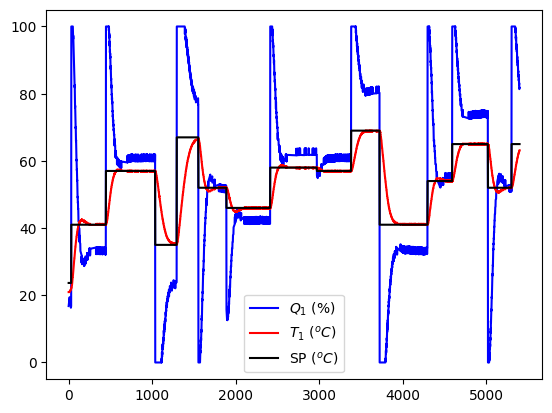

In [33]:
# Save csv file
data = pd.DataFrame()
data['Q1'] = Q1
data['T1'] = T1
data['Tsp'] = Tsp1
data.to_csv('PID_train_data.csv',index=False)

# Plot
plt.plot(data['Q1'],'b-',label='$Q_1$ (%)')
plt.plot(data['T1'],'r-',label='$T_1$ $(^oC)$')
plt.plot(data['Tsp'],'k-',label='SP $(^oC)$')
plt.legend()
plt.savefig('PID_train.png');